## Initial setup
##### This analysis using ema is based on the work of Enayat A. Moallemi created on 22 May 2018 at the Fraunhofer ISI, Karlsruhe. In that instance, the analysis was done for the MATISSE model.

In [1]:

'''
Based on Enayat A. Moallemi version from May 2018

edited by Angela M. Rojas A. <angelara@student.unimelb.edu.au>

Created on February 2020

'''
import sys
import os

sys.path.append(r'C:\Users\angel\Documents\GitHub\gr4sp\experiments\EMAworkbench')

sys.path.append(r'C:\Users\angel\Documents\GitHub\gr4sp\experiments')

#from ema_workbench.analysis.plotting_util import BOXPLOT, KDE, VIOLIN
from ema_workbench.analysis.plotting import envelopes
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import seaborn as sns
from ema_workbench.analysis import prim
#import pareto
import os
import glob
import numpy as np
import pandas as pd
import os
import glob



C:\Users\angel\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\angel\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


## Load the results

In [2]:
from ema_workbench import load_results

#results = load_results(r'C:\Users\angel\Documents\GitHub\gr4sp\experiments\data\gr4sp_2020-Feb-20-years.tar.gz')
#results = load_results(r'C:\Users\angel\Documents\GitHub\gr4sp\experiments\data\gr4sp_2020-Feb-07_EET_allV3.tar.gz')
results = load_results(r'C:\Users\angel\Documents\GitHub\gr4sp\experiments\data\gr4sp_2020-Mar-05-SOBOL.tar.gz')


In [3]:
experiments, outcomes = results

# Create a temporary copy of dictionary, with Outcomes Year
outcomesYear = dict(outcomes)

keysToRemove = [] 
# Iterate over the temporary dictionary and delete corresponding key from original dictionary
for (key, value) in outcomesYear.items() :
    if 'Month' in key:
        keysToRemove.append(key)
        
for k in keysToRemove:        
    del outcomesYear[k]   
    
        

In [4]:
experiments.head()

,annualCpi,annualInflation,capacityFactorChangeBrownCoal,capacityFactorChangeWater,consumption,distributionUsageChange,energyEfficiency,generationRolloutPeriod,generatorRetirement,includePublicallyAnnouncedGen,...,priceChangePercentageWind,retailUsageChange,rooftopPV,semiScheduleGenSpotMarket,semiScheduleMinCapMarketGen,solarUptake,technologicalImprovement,scenario,policy,model
0,0.018789,0.013867,0.0,4.0,1.0,9.0,0.0,9.0,0.0,0.0,...,-8.0,5.0,6.0,10.0,21.79502,2.0,0.05498,None,0,Gr4sp
1,0.048008,0.013867,0.0,4.0,1.0,9.0,0.0,9.0,0.0,0.0,...,-8.0,5.0,6.0,10.0,21.79502,2.0,0.05498,None,1,Gr4sp
2,0.018789,0.031602,0.0,4.0,1.0,9.0,0.0,9.0,0.0,0.0,...,-8.0,5.0,6.0,10.0,21.79502,2.0,0.05498,None,2,Gr4sp
3,0.018789,0.013867,2.0,4.0,1.0,9.0,0.0,9.0,0.0,0.0,...,-8.0,5.0,6.0,10.0,21.79502,2.0,0.05498,None,3,Gr4sp
4,0.018789,0.013867,0.0,9.0,1.0,9.0,0.0,9.0,0.0,0.0,...,-8.0,5.0,6.0,10.0,21.79502,2.0,0.05498,None,4,Gr4sp


In [143]:
#outcomes Options: wholesalePriceYear, GHGYear, tariffsYear, primarySpotProductionYear,
# secondarySpotProductionYear, offSpotProductionYear, rooftopPvProductionYear
# numActorsYear
outcomes_to_show = ['GHGYear','wholesalePriceYear', 'tariffsYear','primarySpotProductionYear', 'secondarySpotProductionYear', 
                    'offSpotProductionYear', 'rooftopPVProductionYear' ]

# 22 levers selected after EET
levers = ['consumption', 'energyEfficiency', 'rooftopPV', 'solarUptake','annualCpi','annualInflation',
          'includePublicallyAnnouncedGen','generationRolloutPeriod','generatorRetirement','technologicalImprovement',
          'priceChangePercentageBrownCoal','priceChangePercentageWind','priceChangePercentageWater','capacityFactorChangeBrownCoal','capacityFactorChangeWater',
          'distributionUsageChange','retailUsageChange',
          'semiScheduleGenSpotMarket','semiScheduleMinCapMarketGen', 'nonScheduleGenSpotMarket', 'nonScheduleMinCapMarketGen', 
          'learningCurve' ]

#from startYear
startYear = 1998
startYearShift = (startYear - 1998)
#startYearShift = (startYear - 1997) * 12
time = outcomes['TIMEYear'][0, startYearShift:]
#index = pd.to_datetime(time, format = '%Y-%m-%d')
index = pd.to_datetime(time, format = '%Y')


In [ ]:
#GHG emissions per household type and population

results = load_households(r'C:\Users\angel\Documents\GitHub\gr4sp\experiments\data\gr4sp_2020-Mar-05-SOBOL.tar.gz')


# Target functions

In [105]:
def target_always_after(outcomes,ooi,targetYear,targetVal,above):
    data = outcomes[ooi]
    num_exp = len(data)
    achieved = np.zeros(num_exp, dtype=bool)

    for i in range(num_exp):
        achieved[i] = False
        exp_run = data[i]
        for j in range( len(exp_run) ):
            if (startYear + j) >= targetYear:
                if above is True:
                    achieved[i] = exp_run[j] >= targetVal
                else:
                    achieved[i] = exp_run[j] < targetVal
                    
                #If the target is not achieved after the TargetYear, then mark experiment as False
                if achieved[i] == False:
                    break
    return achieved

def target_at_year(outcomes,ooi,targetYear,targetVal,above):
    data = outcomes[ooi]
    num_exp = len(data)
    achieved = np.zeros(num_exp, dtype=bool)

    for i in range(num_exp):
        achieved[i] = False
        exp_run = data[i]
        
        idx = targetYear - startYear
        if above is True:
            achieved[i] = exp_run[idx] >= targetVal
        else:
            achieved[i] = exp_run[idx] < targetVal                        
                
    return achieved

# Scenario discovery

## GHG emissions

In [106]:
#truncate experiments and outcomes for a selected policy and a selected outcome over mean in time series
#Subset of SOBOL levers
#selected_levers = list(['rooftopPV', 'annualCpi','capacityFactorChangeBrownCoal','capacityFactorChangeWater','semiScheduleMinCapMarketGen'])    
selected_levers = levers
ooi = 'GHGYear'
data = outcomes[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_levers] 

The following section uses PRIM, feature scoring and dimensional stacking to find the cases that represent futures in three main groups: Low Carbon, Just Transition and Resilient Transition.

It uses targets (e.g. cases for which emissions are the lowest at year x) to filter out the cases and find out the corresponding input variables and ranges for the cases to happen.

The first case is on GHG emissions. To find out the targets for exploration, first let's analyse the envelope diagram (see below) showing how the transition may unfold:

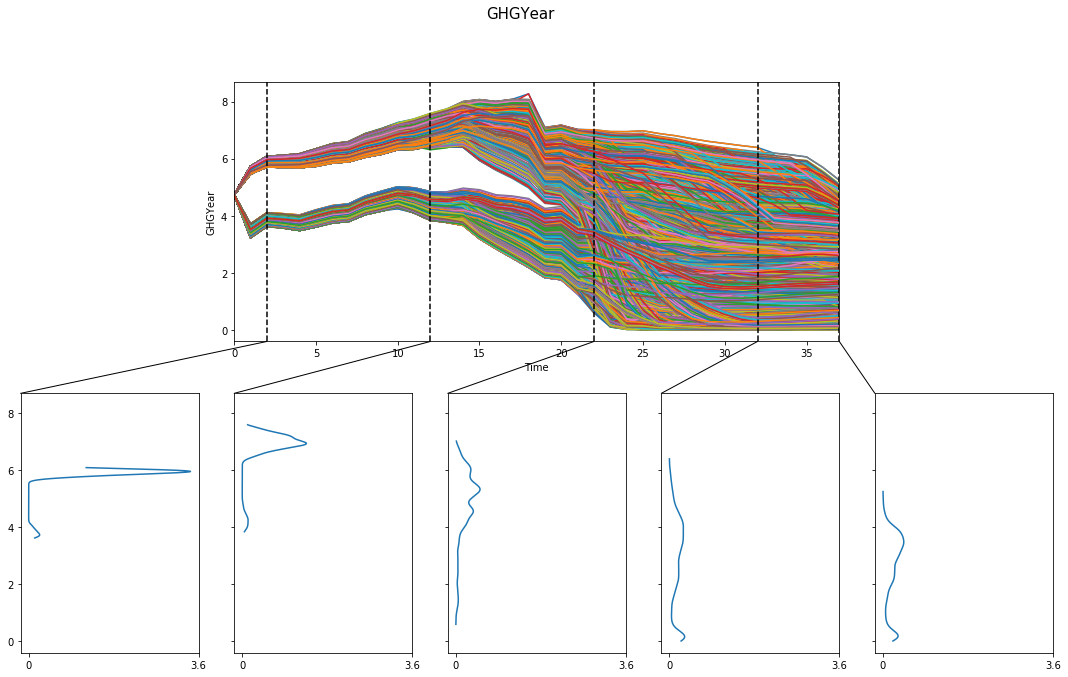

In [9]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density 

fig, ax_env = multiple_densities(experiments, outcomesYear, outcomes_to_show = ooi, 
                                 points_in_time=[2000-startYear,2010-startYear,2020-startYear,2030-startYear,2035-startYear], 
                                 density = Density.KDE, grouping_specifiers=None , titles={ooi}, ylabels={ooi: ooi}, legend=True, 
                                 fill=False, plot_type=PlotType.ENV_LIN)


fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)



As the envelope shows, there are two main groups at the first years of analysis where GHG emissions either increase or decrease. However, as time passes, GHG emissions can vary widely. 
Taking the first year of analysis, year 2000, we can investigate the cases where GHG emissions per year per household fall below 5 tonsCO2-e.

In [114]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);
 
x = exp
#y = (out_avg_ooi < 4.)
y = target_at_year( outcomes, ooi, 2035, 3, False) #False is below target

prim_alg = prim.Prim(x, y, threshold=.5)
box1 = prim_alg.find_box()



[MainProcess/INFO] 47104 points remaining, containing 25382 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.2008109714673913, coverage: 0.37266566858403594, density: 1.0 restricted_dimensions: 6


In [115]:
box1.inspect_tradeoff()

alt.VConcatChart(...)

coverage    0.852657
density     0.782225
id                 2
mass        0.605766
mean        0.782225
res_dim            2
Name: 2, dtype: object

                          box 2                                      
                            min   max                       qp values
semiScheduleGenSpotMarket   8.5  10.0                     [0.0, -1.0]
generationRolloutPeriod     0.5  10.0  [2.8391543212301423e-77, -1.0]



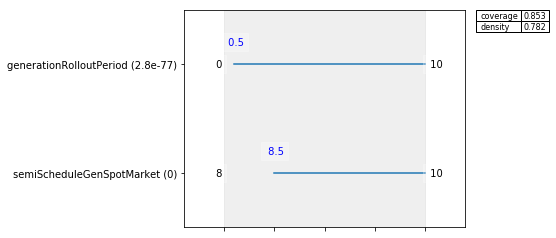

In [19]:
#%matplotlib inline
box_1 = box1.inspect(2)
box_1 = box1.inspect(2, style='graph')


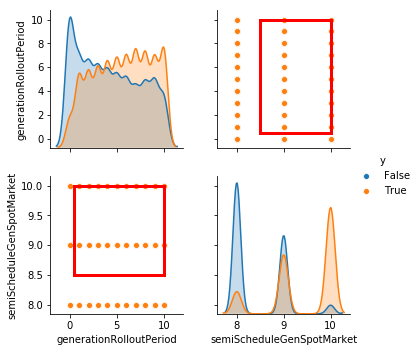

In [20]:
box1.select(2)
fig = box1.show_pairs_scatter(2)

plt.show()


### Feature Scoring

In [22]:
from EMAworkbench.ema_workbench.analysis import feature_scoring

fs, alg = feature_scoring.get_ex_feature_scores(x, y, mode=feature_scoring.RuleInductionType.CLASSIFICATION)
fs.sort_values(ascending=False, by=1)



,1
0,
semiScheduleGenSpotMarket,0.455062
nonScheduleGenSpotMarket,0.127435
generationRolloutPeriod,0.084637
semiScheduleMinCapMarketGen,0.037860
priceChangePercentageWater,0.033782
consumption,0.029701
priceChangePercentageBrownCoal,0.027734
includePublicallyAnnouncedGen,0.022738
capacityFactorChangeBrownCoal,0.016865


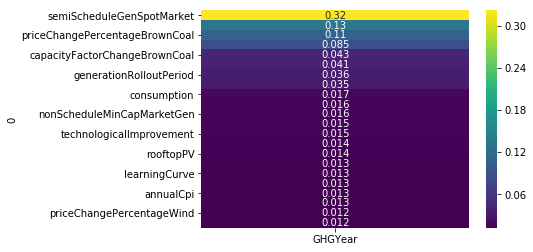

In [23]:
x = exp
y_all = {}
y_all['GHGYear'] = out_avg_ooi

fs = feature_scoring.get_feature_scores_all(x, y_all)
sns.heatmap(fs, cmap='viridis', annot=True)
plt.show()

### Dimensional Stacking


[MainProcess/INFO] model dropped from analysis because only a single category


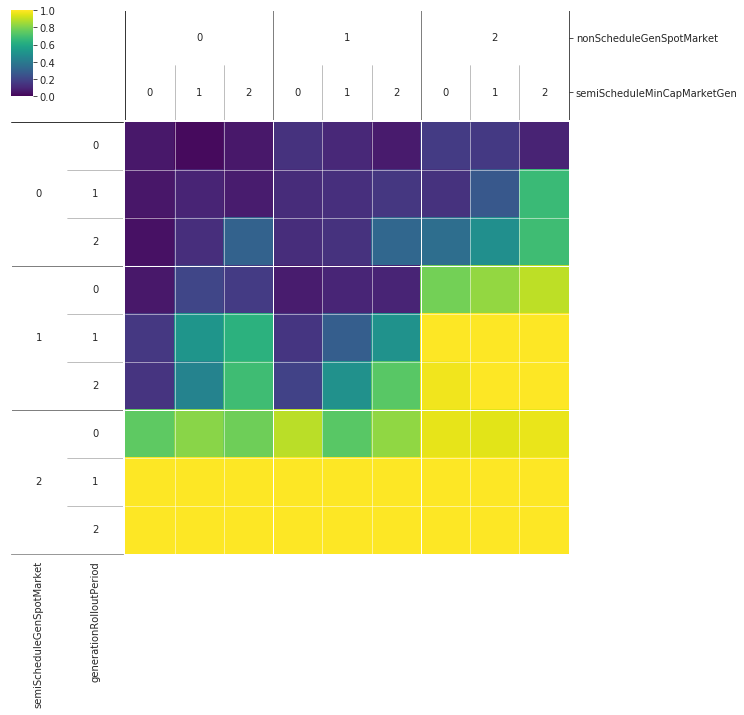

In [24]:

from EMAworkbench.ema_workbench.analysis import dimensional_stacking

x = experiments
dimensional_stacking.create_pivot_plot(x,y, 2, nbins=3)
plt.show()



## Wholesale Price

In [117]:
# Subset Sool levers
selected_levers = list(['rooftopPV','annualCpi', 'generationRolloutPeriod', 'generatorRetirement',
                        'capacityFactorChangeBrownCoal','semiScheduleMinCapMarketGen'])    

#selected_levers = levers
ooi = 'wholesalePriceYear'
data = outcomes[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_levers] 

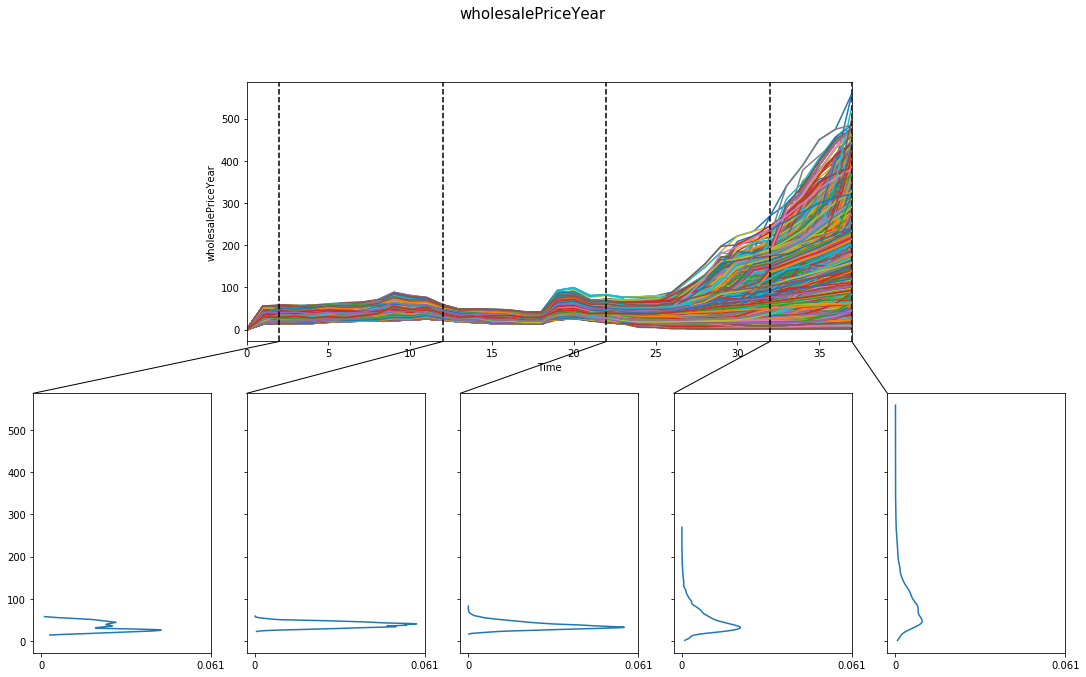

In [29]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density 

fig, ax_env = multiple_densities(experiments, outcomesYear, outcomes_to_show = ooi, 
                                 points_in_time=[2000-startYear,2010-startYear,2020-startYear,2030-startYear,2035-startYear], 
                                 density = Density.KDE, grouping_specifiers=None , titles={ooi}, ylabels={ooi: ooi}, legend=True, 
                                 fill=False, plot_type=PlotType.ENV_LIN)


fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

In [135]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);
 
x = exp
#y = out_avg_ooi > 80

y = target_at_year( outcomes, ooi, 2020, 50, True) #False is below target

prim_alg = prim.Prim(x, y, threshold=.1, threshold_type=prim.ABOVE)
box1 = prim_alg.find_box()

[MainProcess/INFO] 47104 points remaining, containing 3491 cases of interest
[MainProcess/INFO] mean: 0.11509635974304068, mass: 0.11897078804347826, coverage: 0.18476081352048124, density: 0.11509635974304068 restricted_dimensions: 6


In [136]:
box1.inspect_tradeoff()

alt.VConcatChart(...)

coverage    0.590545
density     0.422579
id                 8
mass        0.329462
mean        0.422579
res_dim            2
Name: 8, dtype: object

                              box 8                                     
                                min   max                      qp values
generationRolloutPeriod         0.5   4.5   [9.082152747812458e-70, 0.0]
capacityFactorChangeBrownCoal  -8.5  10.0  [9.117093182379545e-06, -1.0]



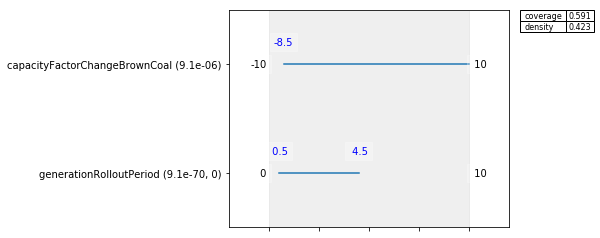

In [129]:
%matplotlib inline
box_1 = box1.inspect(8)
box_1 = box1.inspect(8, style='graph')


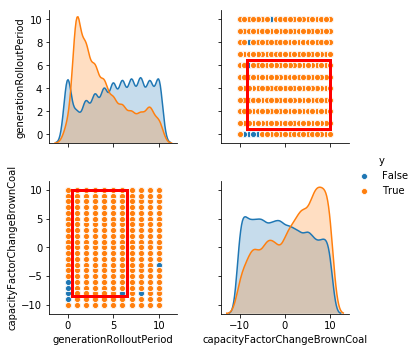

In [53]:
box1.select(6)
fig = box1.show_pairs_scatter(6)

plt.show()

## Tariffs

In [54]:
# Subset Sool levers
selected_levers = list(['consumption','rooftopPV','annualInflation','priceChangePercentageBrownCoal',
                        'priceChangePercentageWind','priceChangePercentageWater',
                        'capacityFactorChangeWater','retailUsageChange'])    

#selected_levers = levers
ooi = 'tariffsYear'
data = outcomes[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_levers] 

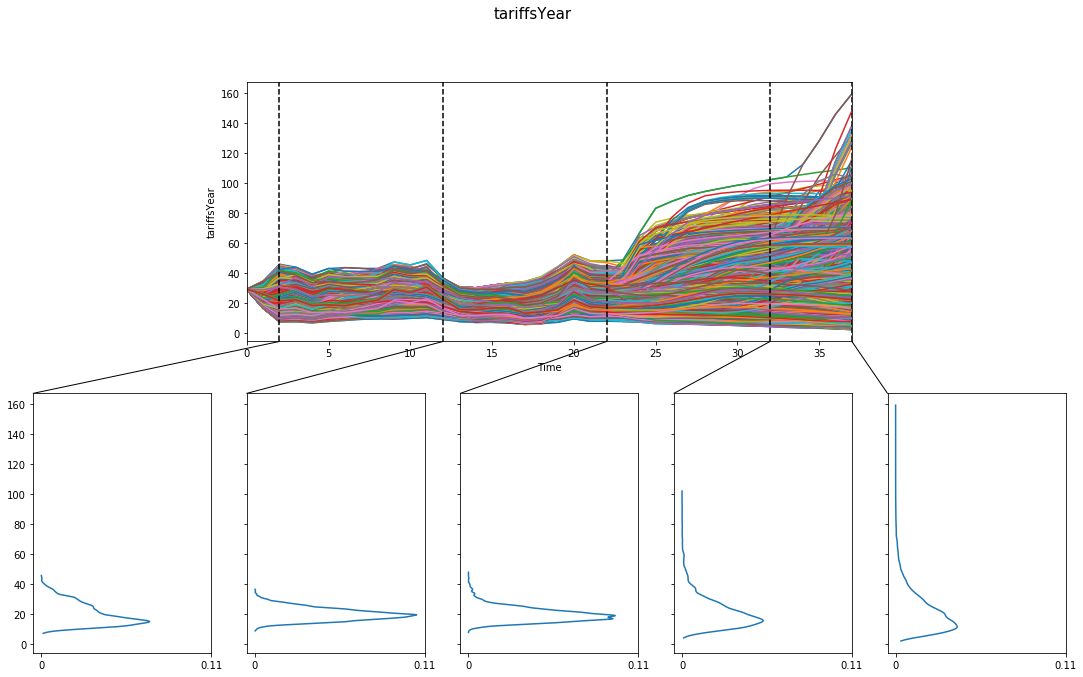

In [55]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density 

fig, ax_env = multiple_densities(experiments, outcomesYear, outcomes_to_show = ooi, 
                                 points_in_time=[2000-startYear,2010-startYear,2020-startYear,2030-startYear,2035-startYear], 
                                 density = Density.KDE, grouping_specifiers=None , titles={ooi}, ylabels={ooi: ooi}, legend=True, 
                                 fill=False, plot_type=PlotType.ENV_LIN)


fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

In [63]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);
 
x = exp
#y = out_avg_ooi > 20

y = target_at_year( outcomes, ooi, 2035, 20, True) #False is below target

prim_alg = prim.Prim(x, y, threshold=.05, threshold_type=prim.ABOVE)
box1 = prim_alg.find_box()

AssertionError: 

In [57]:
box1.inspect_tradeoff()

alt.VConcatChart(...)

coverage    0.344682
density     0.700784
id                21
mass        0.265285
mean        0.700784
res_dim            6
Name: 21, dtype: object

                                  box 21             \
                                     min        max   
annualInflation                  0.01002   0.027422   
retailUsageChange              -10.00000   8.500000   
priceChangePercentageWind      -30.00000  27.500000   
priceChangePercentageBrownCoal -30.00000  27.500000   
priceChangePercentageWater     -30.00000  26.500000   
consumption                      0.50000   4.000000   

                                                                 
                                                      qp values  
annualInflation                 [-1.0, 1.0788769102624623e-230]  
retailUsageChange                 [-1.0, 7.281655074973277e-05]  
priceChangePercentageWind          [-1.0, 0.007720381672216528]  
priceChangePercentageBrownCoal      [-1.0, 0.08361484756095415]  
priceChangeP

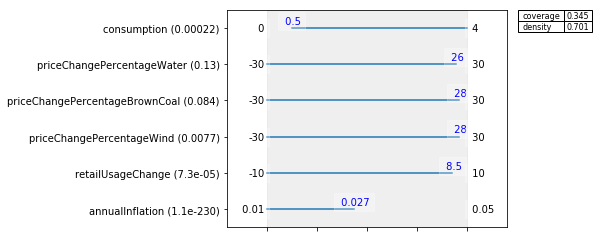

In [59]:
%matplotlib inline
box_1 = box1.inspect(21)
box_1 = box1.inspect(21, style='graph')

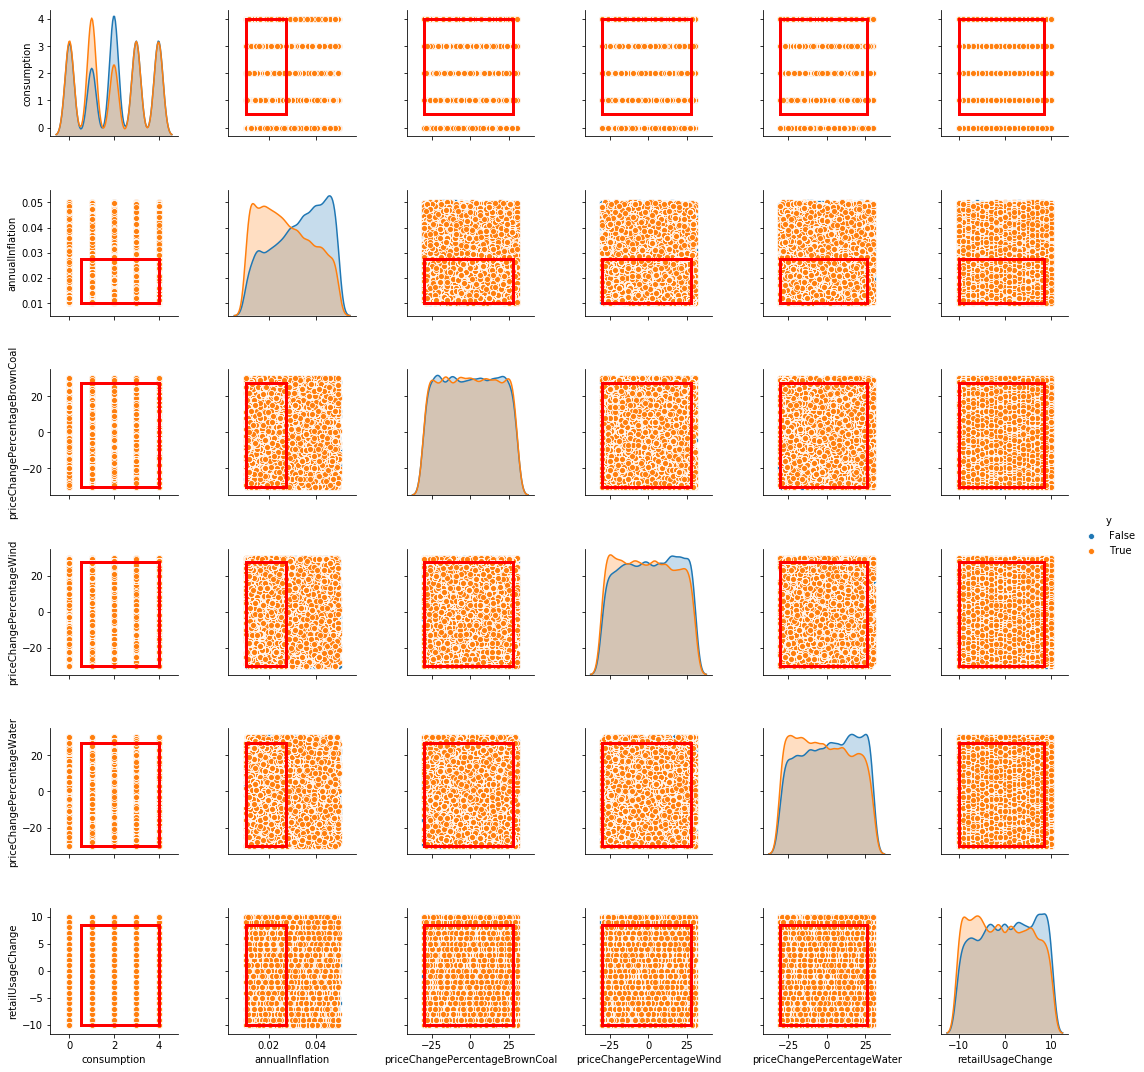

In [60]:
box1.select(21)
fig = box1.show_pairs_scatter(21)
plt.show()

## Primary Spot Production

In [61]:
# Subset Sool levers
selected_levers = list(['annualCpi','priceChangePercentageWind','priceChangePercentageWater',
                        'semiScheduleMinCapMarketGen'])    

selected_levers = levers

ooi = 'primarySpotProductionYear'
data = outcomes[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_levers] 

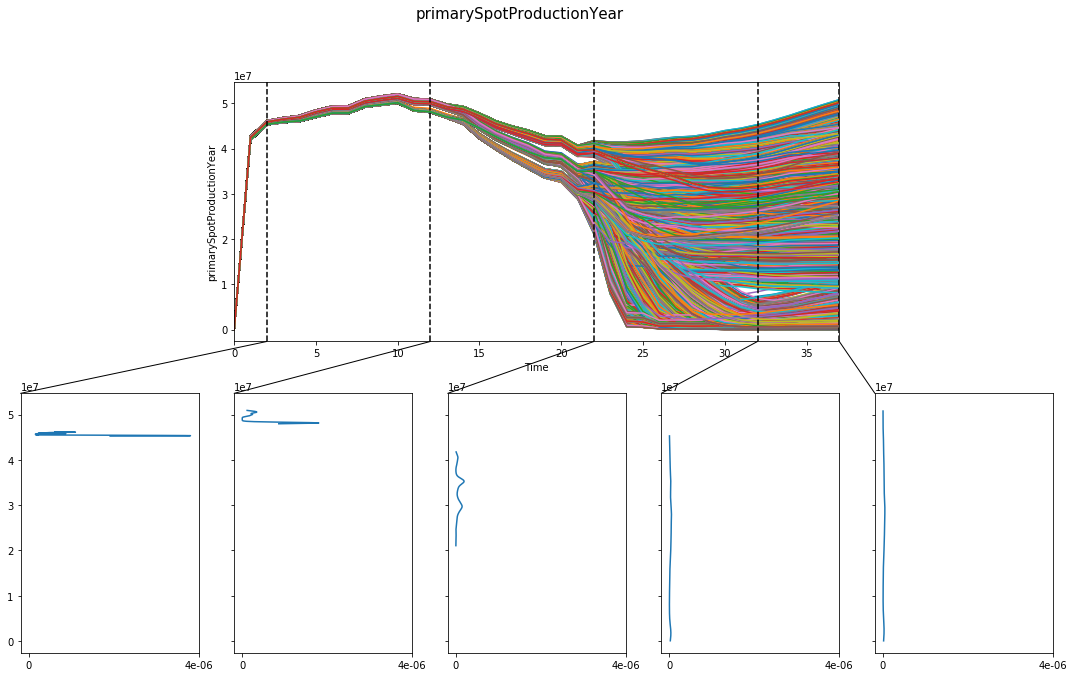

In [62]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density 

fig, ax_env = multiple_densities(experiments, outcomesYear, outcomes_to_show = ooi, 
                                 points_in_time=[2000-startYear,2010-startYear,2020-startYear,2030-startYear,2035-startYear], 
                                 density = Density.KDE, grouping_specifiers=None , titles={ooi}, ylabels={ooi: ooi}, legend=True, 
                                 fill=False, plot_type=PlotType.ENV_LIN)


fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

In [98]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);
 
x = exp
#y = out_avg_ooi > 40000000
y = target_at_year( outcomes, ooi, 2035, 40000000, False) #False is below target

prim_alg = prim.Prim(x, y, threshold=0.3)
box1 = prim_alg.find_box()

AssertionError: 

In [97]:
box1.inspect_tradeoff()

alt.VConcatChart(...)

coverage    0.720491
density     0.908497
id                 2
mass        0.250248
mean        0.908497
res_dim            2
Name: 2, dtype: object

                               box 2                        
                                 min        max    qp values
semiScheduleGenSpotMarket  {primary}  {primary}  [0.0, -1.0]
nonScheduleGenSpotMarket   {primary}  {primary}  [0.0, -1.0]



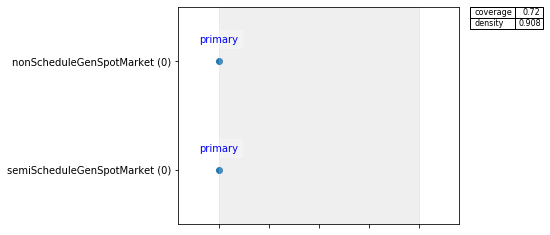

In [204]:
%matplotlib inline
box_1 = box1.inspect(2)
box_1 = box1.inspect(2, style='graph')

In [ ]:
box1.select(2)
fig = box1.show_pairs_scatter(2)
plt.show()

## Secondary Spot Production

In [ ]:
# Subset Sool levers
selected_levers = list(['annualCpi','priceChangePercentageWind','priceChangePercentageWater',
                        'semiScheduleMinCapMarketGen'])    

selected_levers = levers

ooi = 'secondarySpotProductionYear'
data = outcomes[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_levers] 

In [ ]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density 

fig, ax_env = multiple_densities(experiments, outcomesYear, outcomes_to_show = ooi, 
                                 points_in_time=[2000-startYear,2010-startYear,2020-startYear,2030-startYear,2035-startYear], 
                                 density = Density.KDE, grouping_specifiers=None , titles={ooi}, ylabels={ooi: ooi}, legend=True, 
                                 fill=False, plot_type=PlotType.ENV_LIN)


fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

In [ ]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);
 
x = exp
#y = out_avg_ooi > 40000000
y = target_at_year( outcomes, ooi, 2035, 40000000, False) #False is below target

prim_alg = prim.Prim(x, y, threshold=0.3)
box1 = prim_alg.find_box()

In [ ]:
box1.inspect_tradeoff()

In [ ]:
%matplotlib inline
box_1 = box1.inspect(2)
box_1 = box1.inspect(2, style='graph')

In [ ]:
box1.select(2)
fig = box1.show_pairs_scatter(2)
plt.show()

## Rooftop PV Production

In [ ]:
# Subset Sool levers
selected_levers = list(['annualCpi','priceChangePercentageWind','priceChangePercentageWater',
                        'semiScheduleMinCapMarketGen'])    

selected_levers = levers

ooi = 'rooftopPVProductionYear'
data = outcomes[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_levers] 

In [ ]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density 

fig, ax_env = multiple_densities(experiments, outcomesYear, outcomes_to_show = ooi, 
                                 points_in_time=[2000-startYear,2010-startYear,2020-startYear,2030-startYear,2035-startYear], 
                                 density = Density.KDE, grouping_specifiers=None , titles={ooi}, ylabels={ooi: ooi}, legend=True, 
                                 fill=False, plot_type=PlotType.ENV_LIN)


fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

In [ ]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);
 
x = exp
#y = out_avg_ooi > 40000000
y = target_at_year( outcomes, ooi, 2035, 40000000, False) #False is below target

prim_alg = prim.Prim(x, y, threshold=0.3)
box1 = prim_alg.find_box()

In [ ]:
box1.inspect_tradeoff()

In [ ]:
%matplotlib inline
box_1 = box1.inspect(2)
box_1 = box1.inspect(2, style='graph')

In [ ]:
box1.select(2)
fig = box1.show_pairs_scatter(2)
plt.show()

semiScheduleGenSpotMarket ['primary', 'secondary']
nonScheduleGenSpotMarket ['primary', 'secondary']


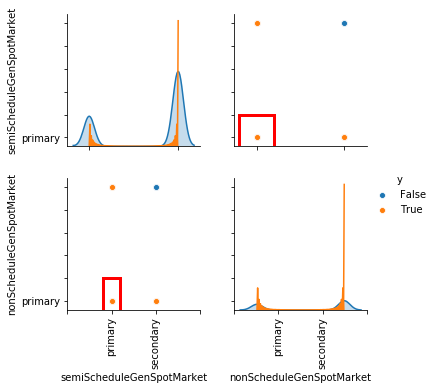

In [205]:
box1.select(2)
fig = box1.show_pairs_scatter(2)
plt.show()

## Secondary Spot Production

In [93]:
# Subset Sool levers
selected_levers = list(['annualCpi','priceChangePercentageWind','priceChangePercentageWater',
                        'semiScheduleMinCapMarketGen'])    

selected_levers = levers

ooi = 'secondarySpotProductionYear'
data = outcomes[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_levers] 

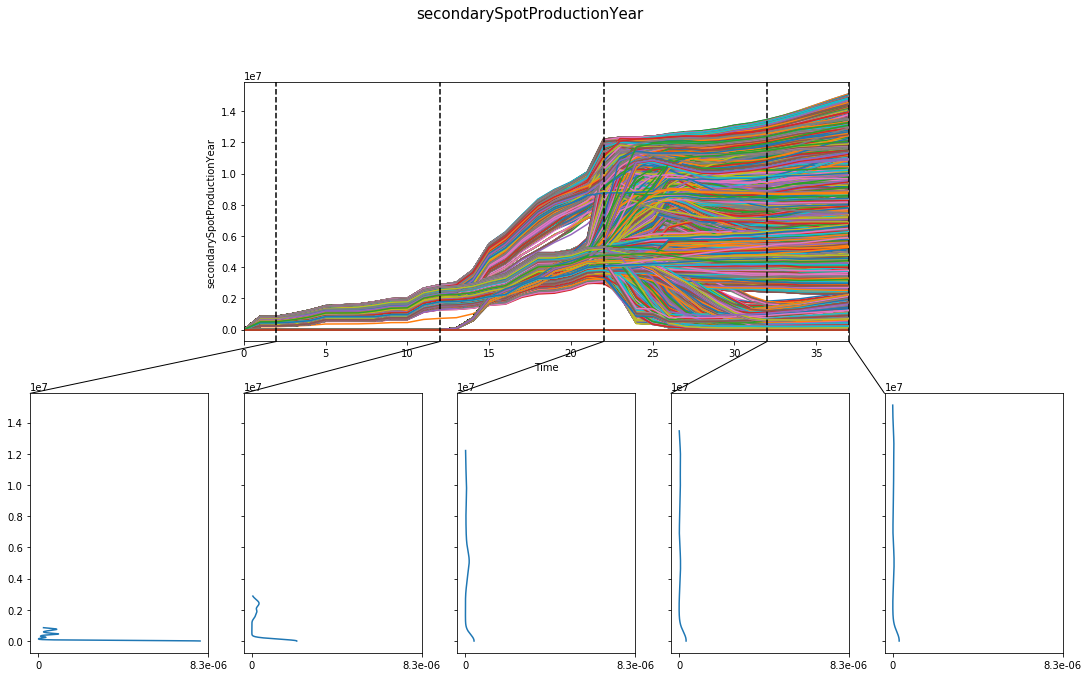

In [94]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density 

fig, ax_env = multiple_densities(experiments, outcomesYear, outcomes_to_show = ooi, 
                                 points_in_time=[2000-startYear,2010-startYear,2020-startYear,2030-startYear,2035-startYear], 
                                 density = Density.KDE, grouping_specifiers=None , titles={ooi}, ylabels={ooi: ooi}, legend=True, 
                                 fill=False, plot_type=PlotType.ENV_LIN)


fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

In [202]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);
 
x = exp
#y = out_avg_ooi > 40000000
y = target_at_year( outcomes, ooi, 2035, 40000000, False) #False is below target

prim_alg = prim.Prim(x, y, threshold=0.3)
box1 = prim_alg.find_box()

[MainProcess/INFO] includePublicallyAnnouncedGen dropped from analysis because only a single category
[MainProcess/INFO] 48300 points remaining, containing 15241 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.16892339544513457, coverage: 0.5353323272751132, density: 1.0 restricted_dimensions: 5


In [203]:
box1.inspect_tradeoff()

alt.VConcatChart(...)

coverage    0.720491
density     0.908497
id                 2
mass        0.250248
mean        0.908497
res_dim            2
Name: 2, dtype: object

                               box 2                        
                                 min        max    qp values
semiScheduleGenSpotMarket  {primary}  {primary}  [0.0, -1.0]
nonScheduleGenSpotMarket   {primary}  {primary}  [0.0, -1.0]



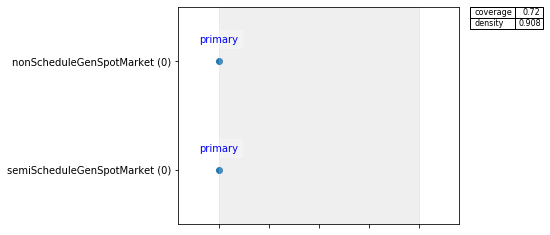

In [204]:
%matplotlib inline
box_1 = box1.inspect(2)
box_1 = box1.inspect(2, style='graph')

semiScheduleGenSpotMarket ['primary', 'secondary']
nonScheduleGenSpotMarket ['primary', 'secondary']


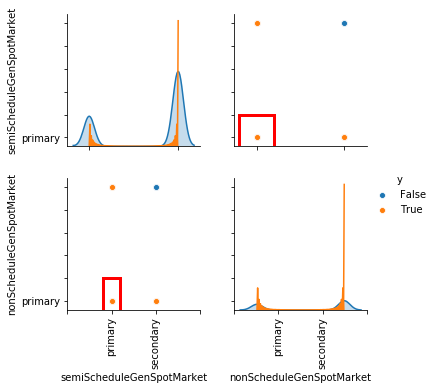

In [205]:
box1.select(2)
fig = box1.show_pairs_scatter(2)
plt.show()

## Rooftop PV Production

In [95]:
# Subset Sool levers
selected_levers = list(['annualCpi','priceChangePercentageWind','priceChangePercentageWater',
                        'semiScheduleMinCapMarketGen'])    

selected_levers = levers

ooi = 'rooftopPVProductionYear'
data = outcomes[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_levers] 

[MainProcess/WARNING] singular matrix


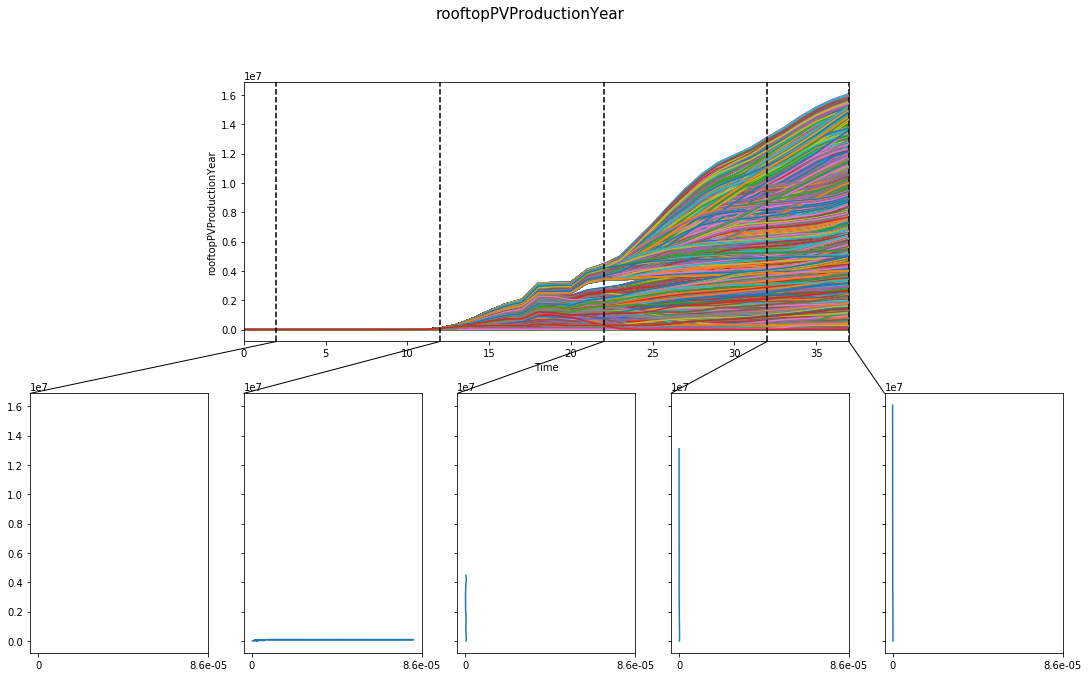

In [96]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density 

fig, ax_env = multiple_densities(experiments, outcomesYear, outcomes_to_show = ooi, 
                                 points_in_time=[2000-startYear,2010-startYear,2020-startYear,2030-startYear,2035-startYear], 
                                 density = Density.KDE, grouping_specifiers=None , titles={ooi}, ylabels={ooi: ooi}, legend=True, 
                                 fill=False, plot_type=PlotType.ENV_LIN)


fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

In [202]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);
 
x = exp
#y = out_avg_ooi > 40000000
y = target_at_year( outcomes, ooi, 2035, 40000000, False) #False is below target

prim_alg = prim.Prim(x, y, threshold=0.3)
box1 = prim_alg.find_box()

[MainProcess/INFO] includePublicallyAnnouncedGen dropped from analysis because only a single category
[MainProcess/INFO] 48300 points remaining, containing 15241 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.16892339544513457, coverage: 0.5353323272751132, density: 1.0 restricted_dimensions: 5


In [203]:
box1.inspect_tradeoff()

alt.VConcatChart(...)

coverage    0.720491
density     0.908497
id                 2
mass        0.250248
mean        0.908497
res_dim            2
Name: 2, dtype: object

                               box 2                        
                                 min        max    qp values
semiScheduleGenSpotMarket  {primary}  {primary}  [0.0, -1.0]
nonScheduleGenSpotMarket   {primary}  {primary}  [0.0, -1.0]



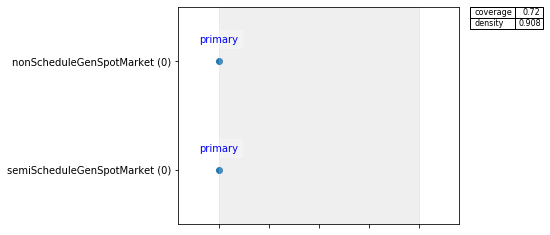

In [204]:
%matplotlib inline
box_1 = box1.inspect(2)
box_1 = box1.inspect(2, style='graph')

semiScheduleGenSpotMarket ['primary', 'secondary']
nonScheduleGenSpotMarket ['primary', 'secondary']


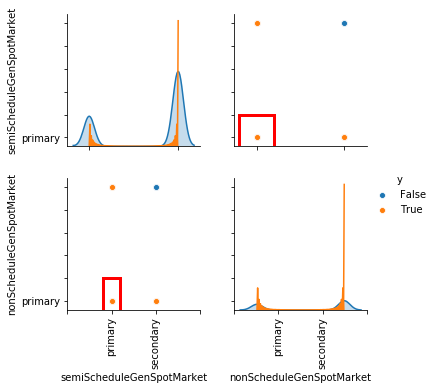

In [205]:
box1.select(2)
fig = box1.show_pairs_scatter(2)
plt.show()